In [1]:
# %matplotlib inline
# najczesciej dla ulatwienia robi sie import pyplot 
import matplotlib.pyplot as plt
from lightkurve import KeplerTargetPixelFile
import numpy as np
import math
from scipy.ndimage import label
from photutils import aperture_photometry
#import scipy
import scipy.ndimage as ndimage
#import scipy.ndimage.filters as filters
from astropy.stats.funcs import median_absolute_deviation as MAD
from skimage.transform import resize
from photutils import DAOStarFinder
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
import os
from scipy.misc import imresize

from scipy import signal
from photutils import find_peaks


In [2]:
 def create_threshold_mask(image, threshold=3, reference_pixel=[10, 10]):

        if len(image.shape) > 2:
            median_image = np.nanmedian(image, axis=0)
        else:
            median_image = image
        vals = median_image[np.isfinite(median_image)].flatten()
        # Calculate the theshold value in flux units
        mad_cut = (1.4826 * MAD(vals) * threshold) + np.nanmedian(median_image)
        # Create a mask containing the pixels above the threshold flux
        threshold_mask = np.nan_to_num(median_image) > mad_cut
        if reference_pixel:
            # return all regions above threshold
            return threshold_mask
        else:
            # Return only the contiguous region closest to `region`.
            # First, label all the regions:
            labels = label(threshold_mask)[0]
            # For all pixels above threshold, compute distance to reference pixel:
            label_args = np.argwhere(labels > 0)
            distances = [np.hypot(crd[0], crd[1])
                         for crd in label_args - np.array([reference_pixel[1], reference_pixel[0]])]
            # Which label corresponds to the closest pixel?
            closest_arg = label_args[np.argmin(distances)]
            closest_label = labels[closest_arg[0], closest_arg[1]]
            return labels == closest_label

In [3]:
file_path = "./b2_lpd.fits"

pixelfile = KeplerTargetPixelFile(file_path)
fluxes = pixelfile.flux / pixelfile.flux.max()

bjd_0 = 2454833. 
bjd = pixelfile.astropy_time.value

In [4]:
anti_aliasing = False
mode = 'bilinear'

/home/pi/anaconda3/envs/astroconda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


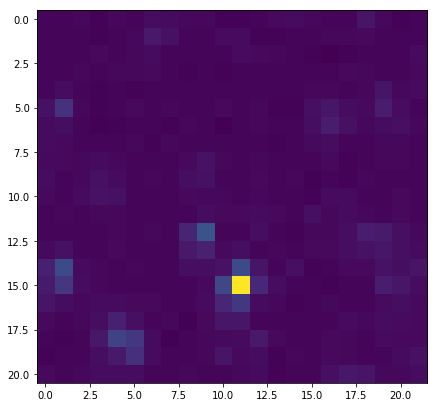

In [5]:
ref_im_num = 0
res_size = 1
th = 1

# ref_im = imresize(fluxes[ref_im_num], (fluxes[ref_im_num].shape[0]*res_size,
#                                        fluxes[ref_im_num].shape[1]*res_size), interp=mode)
ref_im = resize(fluxes[ref_im_num], (fluxes[ref_im_num].shape[0]*res_size,
                                       fluxes[ref_im_num].shape[1]*res_size),
                anti_aliasing=anti_aliasing)

ref_th = create_threshold_mask(ref_im, th)*1
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(ref_im)

In [6]:
fwhm=3.0
threshold=2.

daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*ref_im.std())    
sources = daofind(ref_im - ref_im.mean()) 

In [7]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,18.196964396487317,24.74495569142036,0.46067819716594893,-0.460442950684506,0.04367575604973911,25,0.0,0.0012649602243612326,1.5000186503392121,-0.4402416471209557
2,2.3274038258763454,29.111323561364422,0.3988093776862855,0.4929840307796134,0.6706664340499773,25,0.0,0.0012132418154208674,1.5768982989688365,-0.49450921172918944
3,22.466709976586007,30.535675536429498,0.48293827245181,0.23478950947023966,0.0727461821284962,25,0.0,0.005042886051668854,5.761908748580783,-1.9014159401796071


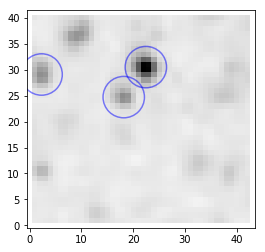

In [8]:
ap_r = 4.

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_r)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(ref_im, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [9]:
ref_aperture_num = 2

ref_position = (sources['xcentroid'][ref_aperture_num],
                sources['ycentroid'][ref_aperture_num])


In [10]:
cor = signal.correlate2d(ref_im, ref_im)
ref_center = np.unravel_index(cor.argmax(), cor.shape)

In [11]:
ref_center

(41, 43)

In [17]:
plot = False
save_file = True
save_plot = True

save_file_output_path = './output'
save_file_prefix = 'ap4'
save_file_ext = 'csv'
dist_limit = 7


phot_tab = []
bkg_tab = []
phot_bkg_tab = []
pos_tab = []
bjd_tab = []
flag_tab = []
ims = []
_range = slice(0, len(fluxes))

In [21]:
for i, frame in enumerate(zip(fluxes[_range], bjd[_range])):
    
    im, bjd_value = frame
    im = resize(im, (im.shape[0]*res_size,
                     im.shape[1]*res_size), anti_aliasing=anti_aliasing)
#     im = imresize(im, (im.shape[0]*res_size,
#                        im.shape[1]*res_size), interp=mode)
    im_th = create_threshold_mask(im, threshold=th)*1
    
    bkg_im = im * ~im_th.astype(bool)
    mean_bkg = np.nanmedian(bkg_im)
    
#     cor = signal.correlate2d(ref_th, im_th)
    cor = signal.correlate2d(ref_im - ref_im.mean(), im - im.mean())

    center = np.unravel_index(cor.argmax(), cor.shape)
    diff_center = (ref_center[0] - center[0], ref_center[1] - center[1])
    new_position = (ref_position[0] + diff_center[0], ref_position[1] + diff_center[1])
    
    aperture = CircularAperture(new_position, r=ap_r+3)
#     phot_table = aperture_photometry(im, aperture)
    
    mask_im = im.copy()
    mask_im[aperture.bounding_boxes[0].slices] = False
    mask_im[mask_im != False] = True
    mask_im = ~mask_im.astype(bool)
    
    tbl = find_peaks((im * mask_im.astype(int))*255 , 2, box_size=3)
    
    
    phot_value = 0
    bkg_value = 0
    phot_bkg_value = 0
    bjd_value = bjd_value - bjd_0
    flag = 0
    
    try:
        tbl.sort('peak_value')
        prec_center = (tbl['x_peak'][-1], tbl['y_peak'][-1])
        aperture = CircularAperture(prec_center, r=ap_r)
        phot_table = aperture_photometry(im, aperture)
        
        if np.sqrt(diff_center[0]**2 + diff_center[1]**2) > dist_limit:
            raise ZeroDivisionError
            
    except ZeroDivisionError:
        print('Distance Error')
        flag = 1
    except (KeyError, TypeError) as e:
        print('Peak Error')
        flag = 2
    else:
        phot_value = phot_table[0]['aperture_sum']
        bkg_value = aperture.area() * mean_bkg
        phot_bkg_value = phot_table[0]['aperture_sum'] - aperture.area() * mean_bkg
    finally:
        phot_tab.append(phot_value)
        bkg_tab.append(bkg_value)
        phot_bkg_tab.append(phot_bkg_value)
        pos_tab.append(diff_center)
        bjd_tab.append(bjd_value)
        flag_tab.append(flag)
        print(i, center, new_position, prec_center)
        
    if plot:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 7))
        ax1.imshow(im)
        aperture.plot(ax=ax1)
        ax2.imshow(im_th)
        ax3.imshow(mask_im)
#         plt.show()
        
    if save_plot:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
        
        ax1.set_title('i: {}'.format(i))
        ax1.imshow(im)
        aperture.plot(ax=ax1)
        
        ax2.set_title('bjd: {}'.format(bjd_value))
        ax2.imshow(im_th)
        
        ax3.set_title('flag: {}'.format(flag))
        ax3.imshow(mask_im)
        
        plt.tight_layout()
        plt.savefig(''.join(['./images/',
                             str(round(bjd_value, 2)).replace('.', '').ljust(8, '0'),
                             '.png']))
        plt.clf() 
        plt.close(f)
        
if save_file:
    save_file = '.'.join(['output', save_file_prefix,
                          os.path.basename(file_path), save_file_ext])
    header = ','.join(['bjd', 'phot_diff', 'phot', 'bkg', 'flag'])
    fmt = '%.10f %.10f %.10f %.10f %d'
    out_tab = np.c_[bjd_tab, phot_bkg_tab, phot_tab, bkg_tab, flag_tab]

    np.savetxt(os.path.join(save_file_output_path, save_file),
               out_tab, delimiter=',', fmt=fmt, header=header)
        

0 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
3 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
4 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
5 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
6 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
7 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
8 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
9 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
10 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
11 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
12 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
13 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
14 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
15 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
16 (41, 43) (22.46

132 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
133 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
134 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
135 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
136 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
137 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
138 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
139 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
140 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
141 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
142 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
143 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
144 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
145 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
146 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
147 (41, 44) (22.466709976586007, 29.535675536429498) (

262 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
263 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
264 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
265 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
266 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
267 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
268 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
269 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
270 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
271 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
272 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
273 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
274 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
275 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
276 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
277 (41, 43) (22.466709976586007, 30.535675536429498) (

392 (41, 43) (22.466709976586007, 30.535675536429498) (23, 30)
393 (41, 43) (22.466709976586007, 30.535675536429498) (23, 30)
394 (41, 43) (22.466709976586007, 30.535675536429498) (23, 30)
395 (41, 43) (22.466709976586007, 30.535675536429498) (23, 30)
396 (41, 43) (22.466709976586007, 30.535675536429498) (23, 30)
397 (41, 43) (22.466709976586007, 30.535675536429498) (23, 30)
398 (41, 43) (22.466709976586007, 30.535675536429498) (23, 30)
399 (41, 43) (22.466709976586007, 30.535675536429498) (23, 30)
400 (41, 42) (22.466709976586007, 31.535675536429498) (23, 30)
401 (41, 42) (22.466709976586007, 31.535675536429498) (23, 30)
402 (41, 42) (22.466709976586007, 31.535675536429498) (23, 30)
403 (41, 42) (22.466709976586007, 31.535675536429498) (23, 30)
404 (41, 42) (22.466709976586007, 31.535675536429498) (24, 30)
405 (41, 42) (22.466709976586007, 31.535675536429498) (24, 30)
406 (41, 42) (22.466709976586007, 31.535675536429498) (24, 30)
407 (41, 42) (22.466709976586007, 31.535675536429498) (

520 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
521 (42, 49) (21.466709976586007, 24.535675536429498) (16, 30)
522 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
523 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
524 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
525 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
526 (41, 49) (22.466709976586007, 24.535675536429498) (16, 30)
527 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
528 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
529 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
530 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
531 (41, 49) (22.466709976586007, 24.535675536429498) (17, 30)
532 (41, 48) (22.466709976586007, 25.535675536429498) (17, 30)
533 (41, 48) (22.466709976586007, 25.535675536429498) (18, 30)
534 (41, 48) (22.466709976586007, 25.535675536429498) (17, 30)
535 (41, 48) (22.466709976586007, 25.535675536429498) (

Distance Error
641 (35, 34) (28.466709976586007, 39.535675536429494) (32, 36)
Distance Error
642 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
643 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
644 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
645 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
646 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
647 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
648 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
649 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
650 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
651 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
652 (35, 33) (28.466709976586007, 40.535675536429494) (32, 36)
Distance Error
653 (35, 33) (28.466709976586007, 40.535675536429

766 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
767 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
768 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
769 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
770 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
771 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
772 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
773 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
774 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
775 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
776 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
777 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
778 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
779 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
780 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
781 (41, 43) (22.466709976586007, 30.535675536429498) (

897 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
898 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
899 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
900 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
901 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
902 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
903 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
904 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
905 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
906 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
907 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
908 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
909 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
910 (42, 44) (21.466709976586007, 29.535675536429498) (22, 30)
911 (42, 44) (21.466709976586007, 29.535675536429498) (22, 30)
912 (42, 44) (21.466709976586007, 29.535675536429498) (

1027 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1028 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1029 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1030 (42, 44) (21.466709976586007, 29.535675536429498) (22, 30)
1031 (41, 44) (22.466709976586007, 29.535675536429498) (21, 32)
1032 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1033 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
1034 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
1035 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1036 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1037 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1038 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1039 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1040 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1041 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1042 (43, 45) (20.466709976586007, 28.53

1156 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1157 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1158 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1159 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1160 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1161 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1162 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1163 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1164 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
1165 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1166 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1167 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1168 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1169 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1170 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1171 (41, 43) (22.466709976586007, 30.53

1284 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1285 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1286 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1287 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1288 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1289 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
1290 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1291 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1292 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1293 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1294 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1295 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1296 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1297 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1298 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1299 (42, 44) (21.466709976586007, 29.53

1413 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1414 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1415 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1416 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1417 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1418 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1419 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1420 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1421 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1422 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1423 (42, 44) (21.466709976586007, 29.535675536429498) (21, 29)
1424 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1425 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1426 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1427 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1428 (41, 43) (22.466709976586007, 30.53

1541 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1542 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1543 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1544 (43, 45) (20.466709976586007, 28.535675536429498) (20, 29)
1545 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1546 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1547 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1548 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1549 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1550 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
1551 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1552 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
1553 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1554 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1555 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1556 (41, 43) (22.466709976586007, 30.53

1670 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1671 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1672 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1673 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1674 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1675 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1676 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1677 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1678 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1679 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1680 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1681 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1682 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1683 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1684 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1685 (42, 45) (21.466709976586007, 28.53

1799 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1800 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1801 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1802 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1803 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1804 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1805 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1806 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1807 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1808 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1809 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
1810 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1811 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1812 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1813 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
1814 (42, 45) (21.466709976586007, 28.53

1927 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1928 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1929 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1930 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1931 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1932 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
1933 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1934 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1935 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
1936 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
1937 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1938 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1939 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1940 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
1941 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
1942 (42, 45) (21.466709976586007, 28.53

2056 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2057 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2058 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2059 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2060 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2061 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2062 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2063 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2064 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2065 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2066 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2067 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2068 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2069 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2070 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2071 (41, 44) (22.466709976586007, 29.53

2185 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
2186 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2187 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2188 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2189 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2190 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2191 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2192 (42, 44) (21.466709976586007, 29.535675536429498) (21, 30)
2193 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2194 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2195 (42, 45) (21.466709976586007, 28.535675536429498) (21, 29)
2196 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
2197 (42, 45) (21.466709976586007, 28.535675536429498) (20, 29)
2198 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2199 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2200 (42, 45) (21.466709976586007, 28.53

2314 (41, 44) (22.466709976586007, 29.535675536429498) (21, 30)
2315 (42, 45) (21.466709976586007, 28.535675536429498) (21, 30)
2316 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2317 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2318 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2319 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2320 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2321 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2322 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2323 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2324 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2325 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2326 (41, 43) (22.466709976586007, 30.535675536429498) (22, 30)
2327 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2328 (41, 44) (22.466709976586007, 29.535675536429498) (22, 30)
2329 (41, 44) (22.466709976586007, 29.53

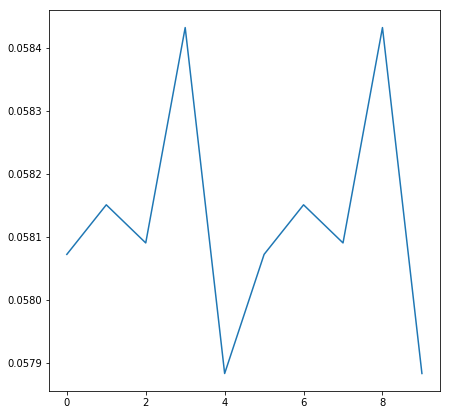

In [189]:
f, (ax1) = plt.subplots(1, 1, figsize=(7, 7))
ax1.plot(phot_bkg_tab)

plt.show()

In [66]:
aperture.area()

50.26548245743669

In [24]:
tbl.add_row([1,2,1])

In [25]:
tbl.sort('peak_value')

In [26]:
tbl

x_peak,y_peak,peak_value
int64,int64,float64
1,2,1.0
18,30,2.806693098245885
1,2,3.0


In [ ]:
fake_im[aperture.bounding_boxes[0].slices] = False
fake_im[fake_im != False] = True
fake_im = ~fake_im.astype(bool)

In [ ]:
from photutils import find_peaks
plt.imshow(im * fake_im.astype(int) )

In [ ]:
tbl = find_peaks((im * fake_im.astype(int))*255 , 1, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])    # print only the first 10 peaks

In [ ]:
tbl['x_peak'][0]

In [ ]:
plt.imshow(cor)
print(np.unravel_index(cor.argmax(), cor.shape))

In [ ]:
out_tab = []
all_tab = []
bkg_tab = []
for im in pixelfile.flux:
    th_im = create_threshold_mask(th_im)
    out_tab.append(im[th_im].sum() - im[~th_im].sum())
    all_tab.append(im.mean())
    

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
# ax.plot(data[:,0], data[:,1]/data[:,1].max())
# ax.plot(lc.time, lc.flux-0.7)
ax.plot(out_tab)


In [ ]:
lc.plot()

In [ ]:
lc = lc.normalize().remove_nans().remove_outliers().fill_gaps()

In [ ]:
lc.plot();


In [ ]:
pixelfile.plot(scale='log', aperture_mask=tpf.pipeline_mask)


In [ ]:
bjd0 = 2454833. # stala odejmowana od czasu
kp = 20          # zczytuj maksymalnie kp pikseli z 'obwodki' 
                # liczac z najjasniejszym               
if kp < 1: kp=1 # kp nie moze byc mniejsze od zera (min 1 piksel)
    
tpf = KeplerTargetPixelFile("./b2_lpd.fits")
bjd = tpf.astropy_time.value
lp, xr, yc = tpf.flux.shape

# l - rozmiar kazdego ze zdjec CCD = xr x yc -(wierszy x kolumn)
# print('l. zdjec, rozmiar (xr,yc):', lp, xr, yc, '\n')
print('{} zdjec, rozmiar xr:{}, yr:{}'.format(lp, xr, yc))

if kp > xr*yc: 
    print('Liczba pikseli do liczenia struminia ', kp, ' > liczba pikseli ccd!')
    kp = xr*yc # nie moze przekroczyc liczby pikseli na ccd
    print('Zredukowano ja do: ',kp)

In [ ]:
proc = 0.007   # procentowe dopuszczalne odchylenie pixela do calkowitego strumienia
l1 = 0         # od ktorego zdjecia ma pokazywac zdjecie
#l2 = 511      # do ktorego ccd rysowac
#bg = 500       # poziom natezen pikseli
kp = 200
#bg1=bg         # do zmiany poziomu natezniej jezeli za malo pikseli w blobie
x0,y0 = 15,10   # startowe zeby kompilator nie krzyczal
xs0,ys0 = 0,0
b=1             # do ramki b=2 rownowazne ramce o boku 5x5
ptl = 1          # rysowac czy nie rysowac 0 tak !=0 nie

# otworz plik do zapisu danych
outlc = open('b2_blob', 'w')
# czy chcesz zapisac?
write = True

# czy chcesz rysowac?
plot = False
# czy chcesz zapisac?
# lepiej użyć enumerate, zwraca counter (i = i + 1) oraz obiekt
# mozesz ograniczyc sie do konkretnych obrazów, np od 10 do 15 
# tpf.flux[10:15]
itim=l1
for i, flux_im in enumerate(tpf.flux[0:lp+1]): 
    # zastap ewentualne osobliwosci zerem
    flux_im[~np.isfinite(flux_im)] = 0
    # ujemnym pikselom przypisz wartosc 0 
    flux_im[flux_im<0] = 0
    # polozenie max piksela    
    a1,a2 = np.unravel_index(flux_im.argmax(), (xr,yc))  # ponoc szybsze

    # jezeli byl skok we wspolrzednych, postaraj sie znalezc maksimum w okolicy gdzie bylo na poprzednim zdjeciu    
    warn=0  # ostrzezenie, ze przeforsowano zmiane wsp., bo ich skok byl za duzy
    if i > 1 and abs(a1-x0) > 4 or abs(a2-y0) > 4:
        kram = flux_im.copy() # zrob kopie zdjecia i wytnij ramke wokol obecnego jansego piksela
        uram = (kram[max(a1-1,0):min(a1+2,yc),max(a2-1,0):min(a2+2,xr)])
        # zaciemnij okolice jasnego piksela
        uram[uram>0] = 0
        # znajdz maksimum w wyciemnionym zdjeciu
        d1,d2 = np.unravel_index(kram.argmax(), (xr,yc))
        
        # sprawdz czy nowe maksimum jest w zblizonej okolicy: 
        if abs(d1-x0) > 4 or abs(d2-y0) < 4:
            warn = 1   # maksimum znalezione po wygaszeniu jasnego piksela na biezacym zdjeciu
            wa1,wa2 = a1,a2 # do wyswietlenia przy pokazywaniu problemu na koncu programu
            a1, a2 = d1, d2 # podstaw poprawione wartosci wsp.
        else:   
            warn = 2   # nie udalo sie odnalezc poprzedniego maksimum
            
    # sprawdz czy obiekt nie siedzi na brzegu
    edge=0  # ostrzezenie o bliskosci brzegu na 3 piksele
    cf = a1-1  
    if cf < 2:  edge=1
    cl = a1+4 
    if cl > yc: edge=1
    rf = a2-1  
    if rf < 2:  edge=1
    rl = a2+4 
    if rl > xr: edge=1

    # mediana tla i wariancja
    img=flux_im.copy()
    xmed=np.median(img) # policz mediane
    uu=flux_im.copy()
    uu=uu-xmed
    uu=uu*uu
    vstd=math.sqrt(sum(uu.flatten())/(xr*yc))  # blad
    
#   ustalam poziom poszukiwan     3 x sigma nad tlem. 
    bg = xmed + 3.*vstd  
    beg= xmed + 2.*vstd # limit ponizej ktorego nie zchodzimy, zeby blob nie pokryl calego zdjecia
#    print('\n tlo_mediana: ',xmed,' +-',vstd,' poziom poszukiwan: ',bg)
    bg1 = bg
        
    # use a boolean condition to find where pixel values are > bg
    blobs = img > bg
    # label connected regions that satisfy this condition. Separate blobs will be signes numbers:
    # matb - matrix with pixels numbered up to nblob number within a consecutive separate blobs:
    matb, nblob = ndimage.label(blobs)
    #    print('\n number of blobs: ',nblob,'\n')
    #    print('\n blob matrix: \n',matb,'\n') 

    # sprawdz czy masz wogole jakies bloby zeby program nie zawieszal sie:
    bre = 0  # wskaznik wyjscia z while bez osiagniecia rezultatu
    mst = 0  # wskaznik, ze st jest juz ustalone i nie trzeba znowu przetwarzac
    while nblob < 1:
        bg1 = bg1 - vstd*0.5
        if bg1 < beg:
#            print('\n no blobs! can`t decrease threshold, the lowest limit is median + 2*sigma:',beg)
            bg1 = beg
            bre = 1
            n = -1 # wskaznik, ze korzystano z ramki st, bo jezeli nie znajduje blob to zlicza z ramki 3x3.
            # wytnij ramke st wokol najjasniejszego piksela +-b pikseli wokol niego (nie przekraczajac brzegow ccd)
            ramk=(flux_im[max(a1-b,0):min(a1+b+1,xr),max(a2-b,0):min(a2+b+1,yc)])            
            st = ramk.copy()
            st = st.flatten()
            break
#        print('\n no blobs! decreasing threshold level bg', bg,' =>', bg1)
        blobs = img > bg1
        matb, nblob = ndimage.label(blobs) 

    if bre == 0:
        n = matb[a1,a2]   # numer blob z maksimum czyli numer blob, ktory Cie interesuje
#        print(' maksimum w blob nr: ',n)           
        mb = matb.copy()   
        mb[mb != n] = 0      # wszystkie bloby poza i wyzeruj
        mb[mb > 0] = 1       # poniewaz jedyny blob jaki zostal moze miec nry > 1 zrob z nich zero 
        img = img * mb       # przemnoz przez macierz 0-1 zeby zostaly zliczenia tylko w danym blobie
        st = img[img > 0]    # dostajesz macierz wartosci jednowierszowa
        mst = 1              # ustalil st nie trzeba przeliczac
    
    # sprawdz czy jest dostateczna liczba pikseli w blobie, bo z jednego to malo co wynika:
    bst=0
    while len(st) < 6 and bre==0:  # jezeli nie st nie jest z ramki (bre==0) lecz ma malo pikseli to:
        bg1 = bg1 - vstd*0.5
        if bg1 < beg:
#            print('\n too few pts to count:',len(st),' can`t decrease threshold, limit is median + 2*sigma:',beg)
            bg1 = beg
            bst = 1
            n = -1 # wskaznik, ze korzystano z ramki st, bo jezeli nie znajduje blob to zlicza z ramki 3x3.
            # wytnij ramke st wokol najjasniejszego piksela +-b pikseli wokol niego (nie przekraczajac brzegow ccd)
            ramk=(flux_im[max(a1-b,0):min(a1+b+1,xr),max(a2-b,0):min(a2+b+1,yc)])
            st = ramk.copy()
            st = st.flatten()
            break
#        print('\n malo pikseli do zliczania natezenia: ',len(st),' zmniejszam threshold do: ',bg1); 
        im = flux_im.copy()
        blobs = im > bg1
        matb, nblob = ndimage.label(blobs)
        mst == 0   # niestety malo bylo pktow w st, trzeba ustalic jeszcze jes ponownie

    if mst == 0 and bst == 0 and bre==0:  # jezeli bst=1 tzn, st jest z ramki.
        n = matb[a1,a2]      # numer blob z maksimum czuli numer blob, ktory Cie interesuje
#        print(' maksimum st w blob nr: ',n)
        mb = matb.copy()
        mb[mb != n] = 0    # wszystkie bloby poza i wyzeruj
        mb[mb > 0] = 1     # poniewaz jedyny blob jaki zostal moze miec nry > 1 zrob z nich zero 
        im = flux_im.copy()
        im = im * mb       # przemnoz przez macierz 0-1 zeby zostaly zliczenia tylko w danym blobie
        st = im[im > 0]  # dostajesz macierz wartosci jednowierszowa
        
    pl,pu = max(0,len(st) - kp), len(st)  # wartosc od (pl) - do (pu) ktorej zliczana ma byc suma pikseli
                                                # nie moze byc pochodzic z wiekszej liczby pikseli niz kp
                                                # ale nie moze przekraczac liczyb pikseli w ramce, stad max(0,...)
    st.sort()      # dostajesz macierz wartosci jednowierszowa posortowana
        
        
    fc=st[pu-1]
    #  bez pierwszego i indeksy zaczynamy od 0 
    s1, pr, k, px, br = fc, 1, len(st)-2, 1, 0  # wartosci poczatkowe px=1 bo jest juz fc
#    print(st)
#    print(len(st))
    # dodaj strumien z pozostalych pikseli ramki 1 (max kp pikseli) 
    while k >= 0 and pr > proc: # sumuj kp-1 pikseli od najjasniejszych
        pr = st[k]/s1
        s1 = s1 + st[k] # strumien z px pikseli
        px = px + 1     # ile jest dodanych pikseli 
        if px == kp :
            br= 1     #  przerwanie nastapilo ze wzgledu na osiagniety limit pikseli
            k = k-1   #  k ma byc zawsze takie samo niezaleznie od drogi zakonczenia
            break
        k = k-1

#    if br==1: 
#        print('\n zakonczono ze wzgledu na osiagniety limit pikseli: ',kp,'\n')
#    else: 
#        print('zalozona dokladnosc osiagnieto po zliczeniu: ', px, 'pikseli');
            
#    s1 = s1 - px*xmed   # odejmij strumien od tla


    k = k+1
#    print(k,fc,st[k],s1, st[k]/s1, kp)
#    se=st[k]/2. # blad od ostatniego dodanego piksela dziele przez 2 bo +- ta wartosc.
    if s1 < 0 and ptl==0: 
        print('natezenie pikseli ujemne - mediana tla za wysoka? brzeg ccd? zdjecie: ',itim,a1,a2,edge)
        print(len(st),'\n',st,'\n')
        print('center at: ',a1,a2,'\n')
        print('ramka    : ',cf,cl,rf,rl,'\n')
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,25))
        # narysuj obrazy splecione z blob
        axs[0].imshow(flux_im)
        ss=flux_im.copy()
        ss[a1,a2]=2000
        axs[1].imshow(mb)
        ramk=(flux_im[max(a1-1,0):min(a1+2,yc),max(a2-1,0):min(a2+2,xr)])
        print('ramk ',ramk)
        ramk[ramk>0]=600
        axs[2].imshow(flux_im)
        plt.show()
        
        break

    if  edge > 0 or warn > 0 : 
        if warn == 1: print('skorygowano polozenie max: ',wa1,wa2,' na ',a1,a2,'  zdjecie: ',itim)
        if warn == 2: 
            print('polozenie max: ',a1,a2,' odbiega od zdjec poprzednich (',x0,y0,') nowe rowniez nie trafia blisko: ',d1,d2)
            print('                          polozenia max. nie skorygowano   zdejcie: ',itim)

        if edge > 0:  print('znalazl cos przy brzegu: zdjecie: ',a1,a2,'  zdjecie: ', itim)
        print(len(st),'\n',st,'\n')
        print('center at: ',a1,a2,'\n')
        print('ramka    : ',cf,cl,rf,rl,'\n')
        if ptl == 0:
            fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,25))
            # narysuj obrazy splecione z blob
            axs[0].imshow(flux_im)
            ss=flux_im.copy()
            ss[a1,a2]=2000
            axs[1].imshow(mb)
            ramk=(flux_im[max(a1-1,0):min(a1+2,yc),max(a2-1,0):min(a2+2,xr)])
            print('ramk ',ramk)
            ramk[ramk>0]=600
            axs[2].imshow(flux_im)
            plt.show()

        
    se = math.sqrt(s1)    
    # wypisz BJD-bjd0, flux, flux_err, l.pix, flux_z_calej_ramki, err_ramki,
    # l.piks w ramce, wsp. max x,y, nr_blob_lub_ramka(-1), threshold, median_sky, nr_zdjecia
    print("{:16.6f}  {:10.1f} {:6.1f} {:3d}   {:3d} {:3d}  {:3d} {:8.1f} {:8.1f}  {:3d}  {:7d}".format(bjd[itim]-bjd0, s1,se,px,a1,a2,n,bg1,xmed,edge,itim))
    
    if write:   # wypisz BJD-bjd0, flux, flux_err, l.pix, wsp.max x y, nr_blob_lub_ramka(-1), threshold, median_sky, nr_zdjecia
        outlc.write("{:16.6f}  {:10.1f} {:6.1f} {:3d}   {:3d} {:3d}  {:3d} {:8.1f} {:8.1f}  {:3d}  {:7d}\n".format(bjd[i]-bjd0, s1,se,px, a1,a2,n, bg1,xmed,edge,itim))

#   ustal srednie polozenie obiektu z 10 pierwszych zdjec, potem odnos sie tylko do tych wspolrzednych        
    if i < 10:     
        xs0 = (xs0*i+a1)/(i+1) # policz srednia polozenia, i zaczyna sie od zera
        ys0 = (ys0*i+a2)/(i+1)
        x0,y0 = xs0,ys0  # zapamietaj wsp. z poprzedniego zdjecia  
        
        
    # wizualizacja
    # czysty obraz, pixele dodatnie (zaciemnione), pixele brane do sumy (czarne)
    if plot:
#        pixels_to_sum = flux_im >= fc
#        pixels_to_sum = ramk1 < fc
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
        # narysuj obrazy splecione z blob
        for i in range(1,nblob+1):
            im=flux_im.copy()
            mb=matb.copy()
            
            mb[mb!=i]=0  # wszystkie bloby poza i wyzeruj
            mb[mb>0]=1   # poniewaz jedyny blob jaki zostal moze miec nry > 1 zrob z nich zero 
            im=im*mb     # przemnoz przez macierz 0-1 zeby zostaly zliczenia tylko w danym blobie
            axs[0].imshow(flux_im)
            axs[1].imshow(mb)
            axs[2].imshow(im)
            plt.show()
                    
    itim=itim+1
outlc.close()

In [ ]:
data = np.genfromtxt('./b2_blob')

In [ ]:
plt.plot(data[:,0], data[:,1])

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
# ax.plot(data[:,0], data[:,1]/data[:,1].max())
ax.plot(lc.time, lc.flux-0.7)
# ax.plot(out_tab)

In [ ]:
lc.time